In [185]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from imutils import img2array, array2img
from cholesky import Cholesky

In [186]:
def process(coords):
    """
    Process the coordinates as:

    - y: the coordinates of the crooked image
    - x: the coordinates of the reference image
    """
    x = [[l[0][0], l[0][1]] for l in coords]
    y = [[l[1][0], l[1][1]] for l in coords]

    x = np.array(x)
    y = np.array(y)
    
    # homogenize coordinates
    y = np.append(y, np.ones((y.shape[0],1)), axis=1)

    return x, y

In [187]:
# read the pickle dump and process
coords = pickle.load(open("./dump/coords.p", "rb"))
x, y = process(coords)

In [188]:
print(x)
print("\n")
print(y)

[[ 411.11290323  260.95519713]
 [ 535.70071685  284.61111111]
 [ 518.35304659  286.18817204]
 [ 310.18100358   29.12724014]
 [ 786.45340502  536.94086022]]


[[ 540.86200717  407.6218638     1.        ]
 [ 515.62903226  532.20967742    1.        ]
 [ 512.47491039  516.4390681     1.        ]
 [ 774.26702509  311.42114695    1.        ]
 [ 261.72222222  784.53942652    1.        ]]


In [189]:
print(x.shape)
print(y.shape)

(5, 2)
(5, 3)


In [190]:
num_pts = y.shape[0]

C = []
for i in range(num_pts):
    C.append(np.hstack([y[i], np.zeros(3).T]))
    C.append(np.hstack([np.zeros(3).T, y[i]]))
C = np.array(C)

In [191]:
d = x.flatten()

In [193]:
C

array([[ 540.86200717,  407.6218638 ,    1.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,  540.86200717,
         407.6218638 ,    1.        ],
       [ 515.62903226,  532.20967742,    1.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,  515.62903226,
         532.20967742,    1.        ],
       [ 512.47491039,  516.4390681 ,    1.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,  512.47491039,
         516.4390681 ,    1.        ],
       [ 774.26702509,  311.42114695,    1.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,  774.26702509,
         311.42114695,    1.        ],
       [ 261.72222222,  784.53942652,    1.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,

In [192]:
d

array([ 411.11290323,  260.95519713,  535.70071685,  284.61111111,
        518.35304659,  286.18817204,  310.18100358,   29.12724014,
        786.45340502,  536.94086022])

In [169]:
A = np.dot(C.T, C)
b = np.dot(C.T, d)

In [170]:
M = Cholesky(A).solve(b)

In [171]:
M

array([ -2.76724623e-02,   9.76770848e-01,   2.81883168e+01,
        -9.95933723e-01,  -5.79152826e-03,   8.01393325e+02])

In [172]:
M = M.reshape(2, 3)

In [173]:
cat_dir = './imgs/'
filepath = os.path.join(cat_dir, 'crooked_cat.png')
img = img2array(filepath, desired_size=(1000, 1000))

In [174]:
img.shape

(1000, 1000, 3)

In [175]:
height = 1000
width = 1000

In [176]:
def affine_grid_generator(height, width, M):
    """
    This function returns a sampling grid, which when
    used with the bilinear sampler on the input img,
    will create an output img that is an affine 
    transformation of the input.

    Input
    -----
    - M: affine transform matrices of shape (2, 3).
    - height: height of the input img.
    - width: width of the input img.

    Returns
    -------
    - normalized grid (-1, 1) of shape (H, W, 2).
      The 3rd dimension has 2 components: (x, y) which are the 
      sampling points of the original image for each point in the
      target image.
    """
    # create normalized 2D grid
    x = np.linspace(-1, 1, width)
    y = np.linspace(-1, 1, height)
    x_t, y_t = np.meshgrid(x, y)

    # convert to homogeneous coordinates
    ones = np.ones(np.prod(x_t.shape))
    sampling_grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
    
    # affine transform sampling grid
    affine_grid = np.dot(M, sampling_grid)
    # affine grid has shape (2, H*W)
    
    # reshape to (H, W, 2)
    affine_grid = affine_grid.reshape(2, height, width)
    # affine_grid = np.moveaxis(affine_grid, 1, -1)

    # sanity check
    print("Transformation Matrix: {}".format(M.shape))
    print("Sampling Grid: {}".format(sampling_grid.shape))
    print("Affine Grid: {}".format(affine_grid.shape))
    
    return affine_grid

def bilinear_sampler(input_img, x, y):
    """
    Performs bilinear sampling of the input img according to the 
    normalized coordinates provided by the sampling grid. Note that 
    the sampling is done identically for each channel of the input.

    To test if the function works properly, output image should be
    identical to input image when M is initialized to identity
    transform.

    Input
    -----
    - input_img: numpy array of shape (H, W, C).
    - grid: x, y which is the output of affine_grid_generator.

    Returns
    -------
    - interpolated img according to grid.
    """
    # grab dimensions
    H, W, C = input_img.shape

    # rescale x and y to [0, W/H]
    x = ((x + 1.) * W) * 0.5
    y = ((y + 1.) * H) * 0.5

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = np.floor(x).astype(np.int64)
    x1 = x0 + 1
    y0 = np.floor(y).astype(np.int64)
    y1 = y0 + 1

    # make sure it's inside img range [0, H] or [0, W]
    x0 = np.clip(x0, 0, W-1)
    x1 = np.clip(x1, 0, W-1)
    y0 = np.clip(y0, 0, H-1)
    y1 = np.clip(y1, 0, H-1)

    # look up pixel values at corner coords
    Ia = input_img[y0, x0]
    Ib = input_img[y1, x0]
    Ic = input_img[y0, x1]
    Id = input_img[y1, x1]

    # calculate deltas
    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)

    # add dimension for addition
    wa = np.expand_dims(wa, axis=2)
    wb = np.expand_dims(wb, axis=2)
    wc = np.expand_dims(wc, axis=2)
    wd = np.expand_dims(wd, axis=2)

    # compute output
    out = wa*Ia + wb*Ib + wc*Ic + wd*Id

    return out

In [177]:
M = np.reshape(M, [2, 3])

In [178]:
affine_grid = affine_grid_generator(1000, 1000, M)

Transformation Matrix: (2, 3)
Sampling Grid: (3, 1000000)
Affine Grid: (2, 1000, 1000)


In [179]:
x_s = affine_grid[0:1, :].squeeze()
y_s = affine_grid[1:2, :].squeeze()

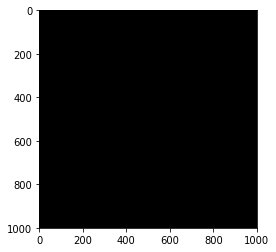

In [180]:
out = bilinear_sampler(img, x_s, y_s)
plt.imshow(out)
plt.show()